<a href="https://colab.research.google.com/github/niikun/DL_for_health_care/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab2

データの準備、基本的な統計の計算、簡単なモデルの構築は、データサイエンスの実践に欠かせないステップです。このラボでは、PyTorchを使ってパイプライン全体を試してみます。具体的には、まずPyTorchでのDNNの実装に慣れる。次に、DNNを使って、前回の診察の診断コードに基づく死亡率予測を行う。

目次

非線形性
PytorchによるDNN
割り当て
前処理
DNNモデル
このラボの内容の一部は、Dive into Deep LearningとOfficial PyTorch Tutoriから引用しています。

In [ ]:
import os
import csv
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# 1. Nonlinearity
これまでは線形回帰モデルを実装していた。しかし、線形モデルは時にうまくいかないことがあります。

これは、線形性が単調性という弱い仮定を意味するからです。つまり、特徴量が増加すると（対応する重みが正の場合）モデルの出力が常に増加するか、（対応する重みが負の場合）モデルの出力が常に減少するかのどちらかでなければなりません。

しかし、単調性に反する例は簡単に思いつく。例えば、体温に基づいて死亡確率を予測したいとします。体温が37℃以上の個体では、体温が高いほどリスクが高いことを示す。しかし、体温が37℃以下の人は、体温が高いほどリスクが低いことを示す！この場合も、巧妙な特徴工学で問題を解決できるかもしれない。すなわち、37℃からの距離を特徴として使うのである。

しかし、診断に基づいて死亡率を予測したい場合はどうだろう。多くの領域知識を必要とする特徴工学を実行するのは非常に難しい。



## 1.2 Incorporating Hidden Layers
線形モデルのこのような制限を克服し、1つ以上の隠れ層を組み込むことで、より一般的なクラスの関数を扱うことができる。これを行う最も簡単な方法は、完全に接続された層をいくつも重ねることだ。各層は、出力を生成するまで、その上の層にフィード・インする。最初の 𝐿−1
  層を表現とし、最後の層を線形予測器と考えることができる。このアーキテクチャは一般に多層パーセプトロンと呼ばれ、しばしば MLP と略されます。以下に、MLP を図式化します。  
  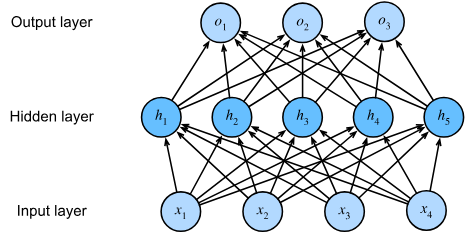

  Formally, this MLP can be expressed as:  

$$
𝐇=𝐗𝐖^{(1)}+𝐛^{(1)},  
𝐎=𝐇𝐖^{(2)}+𝐛^{(2)}
$$

## 1.3 From Linear to Nonlinear
上記のモデルでは、私たちは悩みの割に何も得られないことに驚くかもしれない！理由は簡単だ。上の隠れユニットは入力のアフィン関数で与えられ、出力は隠れユニットのアフィン関数にすぎない。アフィン関数のアフィン関数は、それ自体がアフィン関数なのだ。さらに、私たちの線形モデルはすでにどんなアフィン関数でも表現することができた。つまり  
$$
𝐎=(𝐗𝐖^{(1)}+𝐛^{(1)})𝐖^{(2)}+𝐛^{(2)}=𝐗𝐖^{(1)}𝐖^{(2)}+𝐛^{(1)}𝐖^{(2)}+𝐛^{(2)}=𝐗𝐖+𝐛.
$$
多層アーキテクチャの可能性を実現するためには、もう一つ重要な要素が必要である。
  であり、アフィン変換後の各隠れユニットに適用される。活性化関数の出力（例えば$σ$(⋅)
 )を活性化と呼びます。一般的に、活性化関数が導入されると、MLP を線形モデルに変換することはできなくなります：
 $$
 𝐇=𝜎(𝐗𝐖(1)+𝐛(1)),  
 $$
 $$
 𝐎=𝐇𝐖(2)+𝐛(2).
 $$
 活性化関数は、加重和を計算し、さらにバイアスを加えることによって、ニューロンを活性化すべきかどうかを決定する。活性化関数は入力信号を出力に変換する微分可能な演算子であり、ほとんどの演算子は非線形性を付加する。活性化関数は深層学習の基本であるため、いくつかの一般的な活性化関数について簡単にサーベイしておこう。

**ReLU Function**

実装が簡単で、様々な予測タスクで優れた性能を発揮することから、最も一般的な選択は、整流線形ユニット（ReLU）である。ReLUは非常に単純な非線形変換を提供します。
 :
$$
ReLU(𝑥)=max(𝑥,0).
 $$
直感的に理解するために、関数をプロットしてみましょう。ご覧のように、活性化関数は区分線形です。

Text(0, 0.5, 'relu(x)')

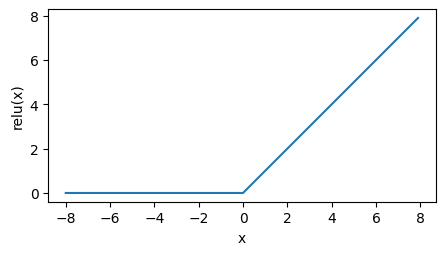

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.relu(x)
plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('relu(x)')

### Exercise 1
Plot the Tanh Function.

Text(0, 0.5, 'tanh(x)')

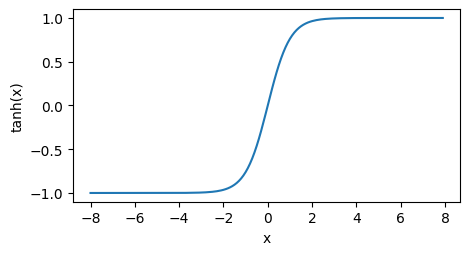

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.tanh(x)
# your code here
# raise NotImplementedError
plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('tanh(x)')

# 2. DNN Model
プログラミングの観点からは、DNNモデルはクラスで表現される。そのサブクラスは、入力を出力に変換する順伝播関数を定義し、必要なパラメータを格納する必要があります。いくつかのサブクラスはパラメータを全く必要としないことに注意。最後に、モデルは勾配を計算するためのバックプロパゲーション関数を持たなければなりません。幸運なことに、独自のモデルを定義するときに自動微分によって提供されるビハインド・ザ・シーンのマジックによって、我々はパラメータと順伝播関数だけを気にすればよい。

以下のコードは、256ユニットとReLU活性化を持つ1つの完全連結隠れ層と、それに続く10ユニットの完全連結出力層（活性化関数なし）を持つネットワークを生成する。

In [ ]:
net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))

In [ ]:
X = torch.rand(2,20)

In [ ]:
print(X,X.shape)

tensor([[0.1145, 0.9396, 0.7600, 0.3430, 0.0917, 0.7671, 0.7386, 0.2736, 0.7380,
         0.6484, 0.9922, 0.7558, 0.5772, 0.0051, 0.9069, 0.9293, 0.3614, 0.4609,
         0.4805, 0.4695],
        [0.7718, 0.5676, 0.0652, 0.6609, 0.1929, 0.6428, 0.7176, 0.2612, 0.8387,
         0.5128, 0.2485, 0.9284, 0.8195, 0.8656, 0.1557, 0.1189, 0.0604, 0.8233,
         0.7916, 0.1952]]) torch.Size([2, 20])


In [ ]:
net(X)

tensor([[ 0.0562, -0.1322,  0.0507,  0.1708, -0.0945,  0.0171,  0.0825,  0.1671,
         -0.1451, -0.0940],
        [-0.0540, -0.2520, -0.0196,  0.1324, -0.1226, -0.0245,  0.0011,  0.1106,
         -0.0641, -0.0733]], grad_fn=<AddmmBackward0>)

この例では、`nn.Sequential`をインスタンス化し、引数としてレイヤーを実行する順番に渡すことでモデルを構築しています。要するに、`nn.Sequential`はPyTorchでモデルを表現するクラスであるModuleの特別な種類を定義しています。`nn.Sequential`は構成されるModuleの順序付きリストを保持します。完全に接続された2つのレイヤーはそれぞれLinearクラスのインスタンスであり、それ自体がModuleのサブクラスであることに注意してください。順伝播（forward）関数も驚くほどシンプルで、リスト内の各ブロックを連結し、それぞれの出力を次のブロックの入力として渡す。これまでは、`net(X)`という構文を使ってモデルを呼び出し、その出力を得ていた。これは実際には`net.__call__(X)`の略記にすぎない。

**A Custom Model**  
モデルがどのように機能するのかを直感的に理解する最も簡単な方法は、自分自身でモデルを実装することでしょう。独自のカスタムモデルを実装する前に、各モデルが提供しなければならない基本的な機能を簡単にまとめておきます：

入力データを順伝播関数の引数として取り込む。
順伝播関数が値を返すことによって出力を生成する。出力は入力と異なる形状を持つ可能性があることに注意。
入力に対する出力の勾配を計算する。通常、これは自動的に行われる。
順伝播計算を実行するために必要なパラメータを格納し、アクセスできるようにする。
必要に応じてモデル・パラメータを初期化する。
以下のスニペットでは、256個の隠れユニットを持つ1つの隠れ層と、10次元の出力層を持つMLPに対応するモデルをゼロからコード化します。以下の MLP クラスは、モデルを表すクラスを継承していることに注意してください。ここでは、親クラスの関数に大きく依存し、独自のコンストラクタ（Python では __init__ 関数）と順伝播関数のみを用意します。

In [ ]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.out = nn.Linear(256,10)

    def forward(self,X):
        return self.out(F.relu(self.hidden(X)))


まず、順伝播関数に注目しよう。この関数は X を入力とし、活性化関数を適用した隠れ表現を計算し、その対数を出力します。

コンストラクタでMLPのレイヤーをインスタンス化し、その後、順伝播関数を呼び出すたびにこれらのレイヤーを呼び出します。いくつかの重要な点に注意してください。まず、カスタマイズした `__init__` 関数は `super().__init__()` によって親クラスの `__init__` 関数を呼び出します。次に、完全に接続された2つのレイヤーをインスタンス化し、`self.hidden`と`self.out`に代入します。新しい演算子を実装しない限り、バックプロパゲーション関数やパラメータの初期化について心配する必要はない。これらの関数はシステムが自動的に生成する。これを試してみよう。

In [ ]:
net = MLP()
net(X)

tensor([[-0.0290,  0.0294, -0.1057,  0.1333, -0.1223, -0.0335, -0.1318,  0.0811,
          0.0977,  0.1717],
        [ 0.0403,  0.0900,  0.0074,  0.1636,  0.0288, -0.1205,  0.0537,  0.1533,
          0.0136,  0.2417]], grad_fn=<AddmmBackward0>)

### Exercise 2 [20 points]  
Implement the following model architecture.  

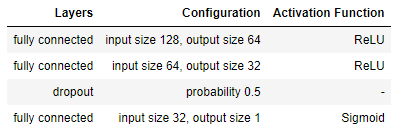

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,32)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32,1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))

        return x

In [ ]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

model = Net()

assert model.fc1.in_features == 128
assert model.fc1.out_features == 64
assert model.fc2.in_features == 64
assert model.fc2.out_features == 32
assert model.fc3.in_features == 32
assert model.fc3.out_features == 1

x = torch.rand(2, 128)
output = model.forward(x)
assert output.shape == (2, 1), "Net() is wrong!"